In [1]:
# Load corpus directory
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [8]:
def load_corpus(path_to_dir: str, start_idx: int = 0, end_idx: int = -1) -> np.array:
    """Load corpus from directory"""
    path_to_dir = os.path.abspath(path_to_dir)
    corpus, authors, titles = [], [], []
    for filename in os.listdir(path_to_dir):
        author, _ = os.path.splitext(os.path.basename(filename))

        with open(os.path.join(path_to_dir, filename), 'r', encoding='utf-8') as f:
            contents = f.read()
        lemmas = contents.lower().split()

        corpus.append(' '.join(lemmas[start_idx:end_idx]))
        authors.append(author[0])
        # title = filename.replace('.txt', '').split('_')[1]
        file_count = filename.replace('.txt', '').split('_')[-1]
        titles.append(file_count)

    return corpus, authors, titles

In [26]:
corpus, authors, titles = load_corpus('../data/corpus')
print(f"Corpus:{len(corpus):>6}\nAuthors:{len(authors):>5}\nTitles:{len(titles):>6}")

Corpus:  1292
Authors: 1292
Titles:  1292


In [14]:
print(corpus[0][:100])
print(authors[:5], authors[-5:])
print(titles[:5], titles[-5:])

14 απριλίου 2022 η επιθετικότητα της ρωσίας στην ουκρανία προκαλεί τεράστια δεινά. επηρεάζει επίσης 
['g', 'g', 'g', 'g', 'g'] ['t', 't', 't', 't', 't']
['001', '002', '003', '004', '005'] ['642', '643', '644', '645', '646']


In [40]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(max_features=1000, token_pattern=r"(?u)\b\w+\b")

v_documents = vect.fit_transform(corpus).toarray()

print(v_documents.shape)
print(vect.get_feature_names_out()[:5])

(1292, 1000)
['0' '00' '000' '1' '10']


In [41]:
from sklearn.preprocessing import normalize

v_documents = normalize(v_documents.astype(float), norm='l1')
v_documents

array([[0.00397351, 0.0013245 , 0.        , ..., 0.        , 0.        ,
        0.00397351],
       [0.00336323, 0.00112108, 0.        , ..., 0.        , 0.        ,
        0.00336323],
       [0.        , 0.00657895, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01428571, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01351351, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01351351, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [42]:
scl = StandardScaler()

s_documents = scl.fit_transform(v_documents)
s_documents.shape

(1292, 1000)

In [43]:
from sklearn.model_selection import train_test_split

test_size = len(set(authors)) * 2

(train_documents, test_documents, train_authors, test_authors) = train_test_split(
    v_documents,  # dataset for split
    authors,      # dataset for split
    test_size=test_size, # size of testing dataset (what is the size?)
    stratify=authors, # preserve the proportion of classes in train and test as in the original dataset
    random_state=42) # perform split according to this 'state'

print(f'{test_documents.shape[0]} test documents with '
      f'{test_documents.shape[1]} features.')

print(f'{train_documents.shape[0]} train documents with '
      f'{train_documents.shape[1]} features.')

print(train_authors)
print(test_authors)

4 test documents with 1000 features.
1288 train documents with 1000 features.
['t', 't', 't', 'g', 't', 'g', 'g', 't', 't', 'g', 't', 't', 'g', 't', 't', 'g', 'g', 'g', 't', 'g', 'g', 't', 't', 't', 't', 'g', 'g', 'g', 't', 'g', 't', 't', 'g', 'g', 'g', 'g', 't', 'g', 't', 'g', 't', 't', 'g', 't', 't', 't', 'g', 'g', 'g', 'g', 'g', 't', 't', 'g', 'g', 't', 'g', 't', 't', 't', 't', 't', 't', 'g', 't', 'g', 't', 't', 't', 'g', 't', 't', 't', 'g', 't', 'g', 't', 'g', 't', 't', 'g', 't', 'g', 'g', 't', 't', 't', 't', 'g', 't', 't', 'g', 't', 't', 'g', 't', 't', 'g', 'g', 'g', 'g', 't', 't', 't', 'g', 'g', 't', 't', 't', 'g', 'g', 'g', 'g', 't', 'g', 'g', 't', 't', 't', 'g', 't', 't', 'g', 'g', 'g', 't', 'g', 'g', 'g', 'g', 'g', 'g', 't', 'g', 'g', 't', 't', 'g', 't', 't', 't', 'g', 'g', 'g', 't', 't', 'g', 't', 'g', 't', 'g', 't', 'g', 'g', 't', 'g', 't', 't', 'g', 't', 't', 'g', 'g', 'g', 't', 't', 'g', 'g', 'g', 't', 't', 'g', 't', 'g', 'g', 't', 't', 't', 'g', 't', 't', 'g', 'g', 'g', '

In [44]:
scl = StandardScaler()

scl.fit(train_documents)

train_documents = scl.transform(train_documents)
test_documents = scl.transform(test_documents)

In [45]:
from scipy.spatial import distance as scidist

distances = scidist.cdist(test_documents, train_documents, metric='cosine')

preds = np.array(train_authors)[np.argmin(distances, axis=1)]
print(preds[:6])

['t' 't' 't' 't']


In [46]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(preds, test_authors)
print(f"Accuracy of predictions: {accuracy:.2f}")

Accuracy of predictions: 0.50


### HCA

In [65]:
from scipy.cluster import hierarchy

# 1. Calculate pairwise distances
dm = scidist.pdist(v_documents, 'cosine')

# 2. Establish branch structure (linkage_object, linking the most similar texts)
linkage_object = hierarchy.linkage(dm, method='complete')

# 3. Visualize
def plot_tree(linkage_object, labels, figsize=(20, 500), ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    with plt.rc_context({'lines.linewidth': 1.0}):
        hierarchy.dendrogram(
            linkage_object, labels=labels, ax=ax,
            orientation='right',
            link_color_func=lambda c: 'black',
            leaf_font_size=10, leaf_rotation=90)
    # Remove ticks and spines
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.autoscale(enable=True) 
    for s in ax.spines.values():
        s.set_visible(False)

In [66]:
plot_tree(linkage_object, authors)

## Principal Component Analysis (PCA)

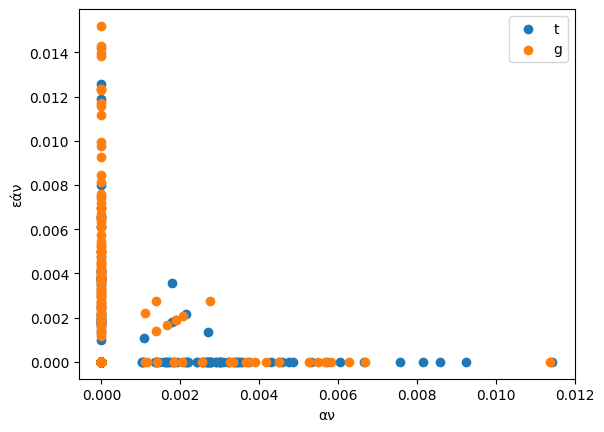

In [72]:
words = vect.get_feature_names()
authors = np.array(authors)
x = v_documents[:, words.index('αν')]
y = v_documents[:, words.index('εάν')]

fig, ax = plt.subplots()
for author in set(authors):
    ax.scatter(x[authors==author], y[authors==author], label=author)
ax.set(xlabel='αν', ylabel='εάν')
plt.legend();

In [73]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
documents_proj = pca.fit_transform(v_documents)

print(v_documents.shape)
print(documents_proj.shape)

(1292, 1000)
(1292, 2)


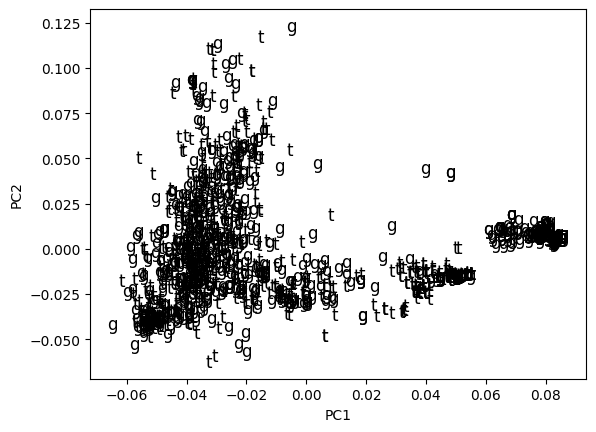

In [74]:
c1, c2 = documents_proj[:, 0], documents_proj[:, 1]

fig, ax = plt.subplots()
ax.scatter(c1, c2, facecolors='none') # empty plot but we need ιτ

for p1, p2, author in zip(c1, c2, authors):
    ax.text(p1, p2, author[0], fontsize=12,
            ha='center', va='center')

ax.set(xlabel='PC1', ylabel='PC2');

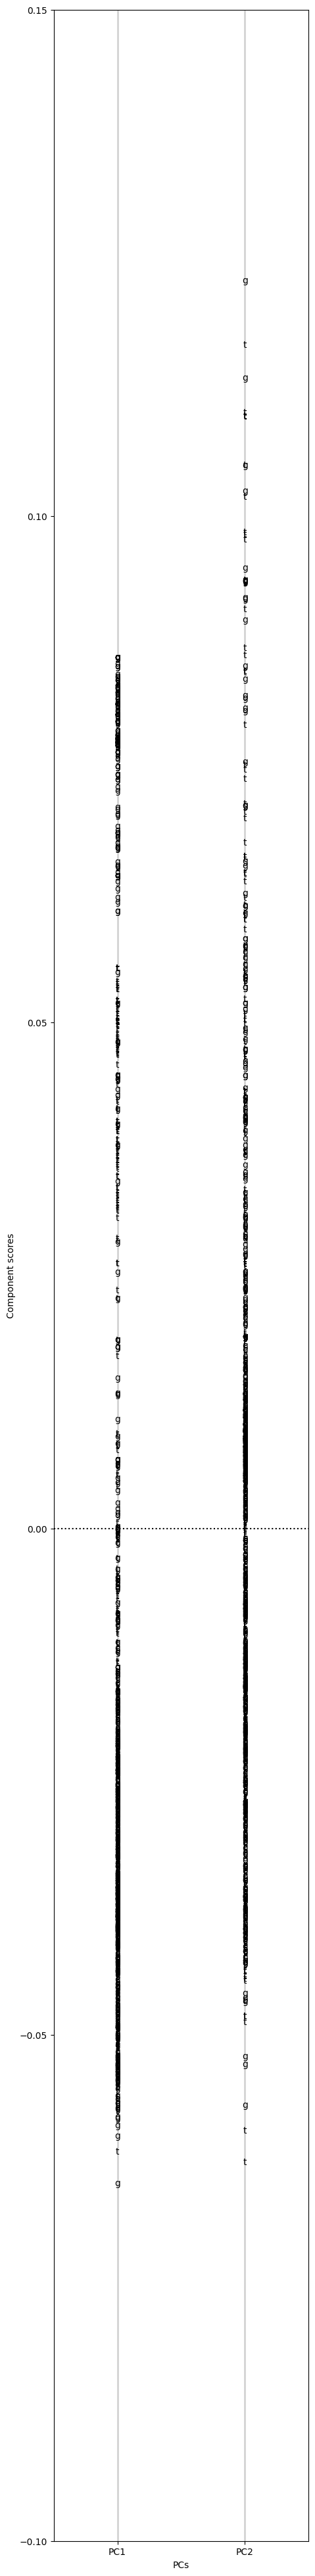

In [82]:
fig, ax = plt.subplots(figsize=(5, 50))

for idx in range(pca.components_.shape[0]):
    ax.axvline(idx, linewidth=2, color='lightgrey')
    for score, author in zip(documents_proj[:, idx], authors):
        ax.text(
            idx, score, author[0], fontsize=10,
            va='center', ha='center')

ax.axhline(0, ls='dotted', c='black')
ax.set(
    xlim=(-0.5, 1.5), ylim=(-0.1, 0.15),
    xlabel='PCs', ylabel='Component scores',
    xticks=[0, 1], xticklabels=['PC1', 'PC2']);